# Importação de bibliotecas

In [15]:
import os
# Run tensorflow on CPU. To run on GPU comment the line above and restart the kernel
# os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.api.datasets import cifar10
from keras.api.models import Sequential
from keras.api.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.api.utils import to_categorical

# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow._api.v2.image import rgb_to_grayscale

from sklearn.model_selection import StratifiedKFold

from typing import ByteString
from enum import Enum

from utils.model_utils import print_history, plot_history, plot_image

# Importação do dataset

In [2]:
def decode_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file, encoding='bytes')

In [3]:
datasets_dir_path = os.path.join(os.getcwd(), "datasets", "cifar")

# TODO: Atualizar para pegar o caminho de todos os 5 datasets
dataset_treinamento_1: dict = decode_pickle(os.path.join(datasets_dir_path, 'data_batch_1'))
dataset_treinamento_2: dict = decode_pickle(os.path.join(datasets_dir_path, 'data_batch_2'))
dataset_treinamento_3: dict = decode_pickle(os.path.join(datasets_dir_path, 'data_batch_3'))
dataset_treinamento_4: dict = decode_pickle(os.path.join(datasets_dir_path, 'data_batch_4'))
dataset_treinamento_5: dict = decode_pickle(os.path.join(datasets_dir_path, 'data_batch_5'))

datasets_meta: dict = decode_pickle(os.path.join(datasets_dir_path, 'batches.meta'))
dataset_validacao: dict = decode_pickle(os.path.join(datasets_dir_path, 'test_batch'))

In [4]:
print("Treinamento: ", dataset_treinamento_1.keys())
print("Validacao: ", dataset_validacao.keys())
print("Meta: ", datasets_meta.keys())

Treinamento:  dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Validacao:  dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Meta:  dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])


In [5]:
CIFAR_BATCH_LABEL = b'batch_label'
CIFAR_LABELS = b'labels'
CIFAR_DATA = b'data'
CIFAR_FILENAMES = b'filenames'
CIFAR_DATASET_SHAPE = (10000, 3, 32, 32)

CIFAR_META_LABEL_NAME= b'label_names'
CIFAR_META_NUM_CASES_PER_BATCH= b'num_cases_per_batch'
CIFAR_META_NUM_VIS= b'num_vis'

In [6]:
def get_label_name(label_index: np.int8) -> str:
    return datasets_meta[CIFAR_META_LABEL_NAME][label_index].decode('utf-8')

## Tratando os dados

In [7]:
entrada_teste = np.array(dataset_validacao[CIFAR_DATA]).reshape(CIFAR_DATASET_SHAPE)
saida_teste = np.array(dataset_validacao[CIFAR_LABELS])

In [8]:
entradas_1 = np.array(dataset_treinamento_1[CIFAR_DATA]).reshape(CIFAR_DATASET_SHAPE)
saida_1 = np.array(dataset_treinamento_1[CIFAR_LABELS])
nomes_1 = np.array(dataset_treinamento_1[CIFAR_FILENAMES])

entradas_2 = np.array(dataset_treinamento_2[CIFAR_DATA]).reshape(CIFAR_DATASET_SHAPE)
saida_2 = np.array(dataset_treinamento_2[CIFAR_LABELS])
nomes_2 = np.array(dataset_treinamento_2[CIFAR_FILENAMES])

entradas_3 = np.array(dataset_treinamento_3[CIFAR_DATA]).reshape(CIFAR_DATASET_SHAPE)
saida_3 = np.array(dataset_treinamento_3[CIFAR_LABELS])
nomes_3 = np.array(dataset_treinamento_3[CIFAR_FILENAMES])

entradas_4 = np.array(dataset_treinamento_4[CIFAR_DATA]).reshape(CIFAR_DATASET_SHAPE)
saida_4 = np.array(dataset_treinamento_4[CIFAR_LABELS])
nomes_4 = np.array(dataset_treinamento_4[CIFAR_FILENAMES])

entradas_5 = np.array(dataset_treinamento_5[CIFAR_DATA]).reshape(CIFAR_DATASET_SHAPE)
saida_5 = np.array(dataset_treinamento_5[CIFAR_LABELS])
nomes_5 = np.array(dataset_treinamento_5[CIFAR_FILENAMES])

entradas = np.append(entradas_1, entradas_2, axis=0)
entradas = np.append(entradas, entradas_3, axis=0)
entradas = np.append(entradas, entradas_4, axis=0)
entradas = np.append(entradas, entradas_5, axis=0)
print(entradas.shape)

saida = np.append(saida_1, saida_2, axis=0)
saida = np.append(saida, saida_3, axis=0)
saida = np.append(saida, saida_4, axis=0)
saida = np.append(saida, saida_5, axis=0)
print(saida.shape)

nomes = np.append(nomes_1, nomes_2, axis=0)
nomes = np.append(nomes, nomes_3, axis=0)
nomes = np.append(nomes, nomes_4, axis=0)
nomes = np.append(nomes, nomes_5, axis=0)
print(nomes.shape)

(50000, 3, 32, 32)
(50000,)
(50000,)


In [9]:
# Transformando para escala cinza
entradas = entradas.astype('float32')
entradas_transpose = np.transpose(entradas, [0, 2, 3, 1])
entradas_gray = rgb_to_grayscale(
    entradas_transpose
).numpy()
entradas_gray /= 255

entrada_teste = entrada_teste.astype('float32')
entrada_teste_transpose = np.transpose(entrada_teste, [0, 2, 3, 1])
entrada_teste_gray = rgb_to_grayscale(
    entrada_teste_transpose
).numpy()
entrada_teste_gray /= 255

print("Treinamento: ", entradas_gray.shape)
print("Teste: ", entrada_teste_gray.shape)


I0000 00:00:1721334345.351106  261060 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721334345.384402  261060 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721334345.384446  261060 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721334345.386312  261060 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721334345.386344  261060 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Treinamento:  (50000, 32, 32, 1)
Teste:  (10000, 32, 32, 1)


## Visualizando alguns itens do dataset

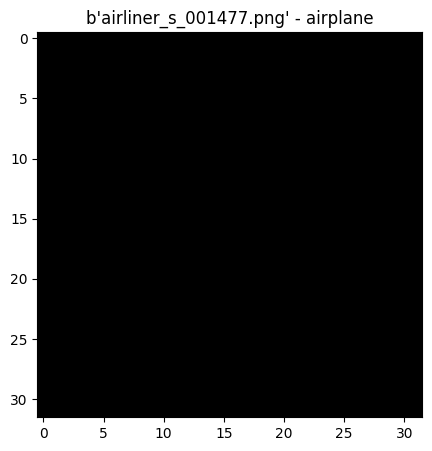

In [10]:
image_index = np.random.randint(0, len(nomes))
image_title = nomes[image_index]
image_data = entradas_gray[image_index]
image_label = saida[image_index]

fig, ax = plt.subplots(figsize=(9,5), nrows=1, ncols=1)
ax.set_title(f"{image_title} - {get_label_name(image_label)}")
ax.imshow(image_data.astype('uint8'), cmap='grey')

plt.show()

In [11]:
# Aplicando OneHotEncoder
saida_encoded = pd.get_dummies(saida)
saida_teste_encoded = pd.get_dummies(saida)

# Criando a Rede Neural Convolucional

In [12]:
# Estrutura da rede
## 1. Convolução
## 2. Pooling (Max Pooling)
## 3. Flattening
## 4. Rede Neural Densa (Classificdor)

def criar_modelo(shape_entrada = (32, 32, 1)):
    sequencial = Sequential(
        name="CIFAR-10",
        layers=[
            Input(
                shape=shape_entrada
            )
        ]
    )

    sequencial.add(
        Conv2D(
            filters=128,
            kernel_size=(3, 3),
            activation='relu'
        )
    )

    sequencial.add(
        BatchNormalization()
    )

    sequencial.add(
        MaxPooling2D(
            pool_size=(2, 2)
        )
    )

    sequencial.add(
        Flatten()
    )

    sequencial.add(
        Dense(
            units=256,
            activation='relu',
        )
    )
    sequencial.add(
        Dropout(rate=0.2)
    )

    sequencial.add(
        Dense(
            units=256,
            activation='relu',
        )
    )
    sequencial.add(
        Dropout(rate=0.2)
    )

    sequencial.add(
        Dense(
            units=10,
            activation='softmax'
        )
    )

    sequencial.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return sequencial
    

In [13]:
modelo = criar_modelo(entradas_gray.shape[1:])

In [14]:
resultado = modelo.fit(
    x=entradas_gray,
    y=saida_encoded,
    batch_size=128,
    epochs=100,
    verbose=1
)

# 254 - 303ms/step -> CPU
## 278,5ms / step -> 1,815 min / epoch -> ~3 horas para treinar
# 35 - 43ms/step -> GPU
## 39ms / step -> 15,249 s / epoch -> ~25 minutos para treinar

Epoch 1/100


I0000 00:00:1721334439.435536  261300 service.cc:146] XLA service 0x7fecc800b860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721334439.435595  261300 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce MX450, Compute Capability 7.5
2024-07-18 17:27:19.470230: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-18 17:27:19.615146: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  5/391 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.1345 - loss: 3.1365

I0000 00:00:1721334442.419382  261300 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.3840 - loss: 1.8117
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.6026 - loss: 1.1348
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.6903 - loss: 0.8937
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.7561 - loss: 0.7043
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.8144 - loss: 0.5396
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.8540 - loss: 0.4281
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.8853 - loss: 0.3366
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.9007 - loss: 0.2870
Epoch 9/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.9198 - loss: 0.2410
Epoch 10/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.9299 - loss: 0.2082
Epoch 11/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.9370 - loss: 0.1913
Epoch 12/100
391/391 ━━━━━━━━━━

Precisão de treinamento:  95.7706198990345 %
Perda de treinamento:  0.13111888408660888


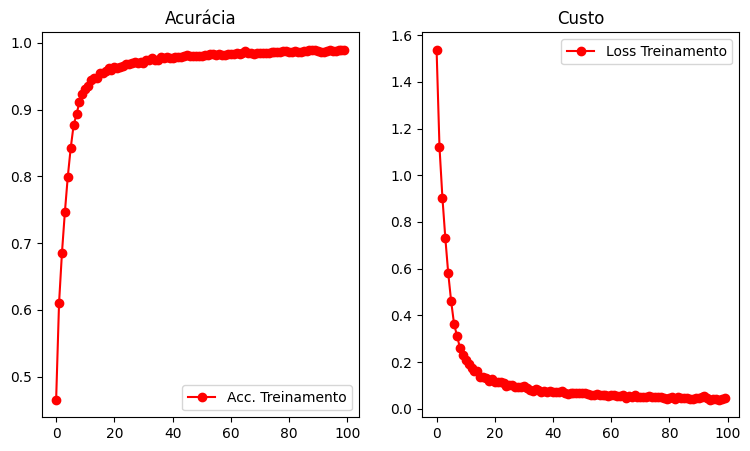

In [16]:
print_history(resultado)
plot_history(resultado)